# Data Exploration


Also need to think about how to handle the multiple waves per person. Options:
1. Keep all waves (will need to use panel data methods)
2. Keep only one wave per person (will need to decide which wave to keep - most recent? random?)
3. Average across waves (will need to decide how to handle missing data - if a person is missing in one wave but not another, do we keep the non-missing value?)
4. Use only the first wave a person appears in (will lose a lot of data, but will be simpler to analyze)

**Reminder**
- Independent variable = X = informal institutions = nbrsnci_dv = Higher values represent greater cohesion, ranging from 1 “lowest cohesion” to 5 “highest cohesion”.
- Dependent variable = Y = subjective wellbeing = scghq1_dv = Range of scores from 0 (indicating the least amount of distress) to 36 (indicating the greatest amount of distress)

In [25]:
import pandas as pd                                 
from pathlib import Path                           
import matplotlib.pyplot as plt                     
import seaborn as sns                              
import numpy as np                                  
from scipy.stats import norm                        
from sklearn.preprocessing import StandardScaler    
from scipy import stats                             
import statsmodels.api as sm                       
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)  # Show all columns when displaying a dataframe
import pyreadstat

In [26]:
# Import file

path = "/Users/arikatz/VSCode Projects/ukhls-informal-institutions-project/data/refinedvariables.dta"
df, meta = pyreadstat.read_dta(path)

print("Shape:", df.shape)
df.head()

Shape: (175335, 18)


,pidp,wave,wave_num,hidp,nbrsnci_dv,gor_dv,urban_dv,sex_dv,age_dv,ethn_dv,marstat_dv,jbstat,fimnnet_dv,fihhmnnet1_dv,houscost1_dv,health,scghq1_dv,hiqual_dv
0,22445,f,6,278664010,3.4,7,1,2,29,1,6,2,2012.000000,NaN,NaN,2,25,3
1,22445,i,9,277344816,3.3,7,1,2,33,1,1,2,1289.699951,1289.699951,1300.0,2,11,3
2,22445,l,12,276637622,1.6,7,1,2,35,1,1,6,145.169998,4146.390137,1350.0,2,32,1
3,29925,f,6,620547610,4.1,7,1,2,37,1,5,1,2175.620117,2175.620117,1451.0,1,11,1
4,29925,i,9,619024416,3.5,7,1,2,40,1,4,2,2904.530029,2904.530029,0.0,1,9,1


In [27]:
# Create a table showing the number of observations in each wave

wave_table = df['wave'].value_counts().sort_index()

display(wave_table)

wave
a    37988
c    40509
f    35472
i    33137
l    28229
Name: count, dtype: int64

Great! For now, I'll just use data from wave C, which has the highest number of observations.

In [28]:
# Drop all waves except wave c

df = df[df['wave'] == 'c']
print("Shape after dropping waves:", df.shape)

Shape after dropping waves: (40509, 18)


## Transforming the explanatory variables

1. Drop all rows with missing values
2. Drop all rows with negative values (i.e. those that indicate "not applicable" or "don't know")
3. Define variables as categorical or continuous, and adjust values accordingly
    - One-hot encode categorical variables
    - Transform binary variables to 0/1
    - Scale continuous variables (standardize to mean 0, sd 1)

Lets start off by identifying which variables are causing the most unusable values

In [29]:
# Calculate % missing and % negative for each column
missing_pct = df.isnull().mean() 
negative_pct = (df.select_dtypes(include=['number']) < 0).mean() * 100   #'number' includes int, float, etc.

# Combine into a summary DataFrame and sort by the sum of % missing and % negative (descending)
summary = pd.DataFrame({
    '% Missing': missing_pct,
    '% Negative': negative_pct
}).fillna(0) # Fill NaN values with 0 for non-numeric columns

summary['% Total'] = summary['% Missing'] + summary['% Negative']
summary = summary.sort_values(by='% Total', ascending=False)

summary.head(10)

,% Missing,% Negative,% Total
hiqual_dv,0.0,0.459157,0.459157
ethn_dv,0.0,0.088869,0.088869
fimnnet_dv,0.0,0.078995,0.078995
fihhmnnet1_dv,0.0,0.029623,0.029623
health,0.0,0.029623,0.029623
gor_dv,0.0,0.017280,0.017280
urban_dv,0.0,0.017280,0.017280
age_dv,0.0,0.002469,0.002469
marstat_dv,0.0,0.002469,0.002469
jbstat,0.0,0.002469,0.002469


This is helpful! It doesn't look like any variables are particularly problematic, so I'll just drop rows with any missing or negative values.

In [30]:
# Record shape before dropping rows with missing or negative values
initial_shape = df.shape

# Drop rows with any missing or negative values
df = df.dropna()
df = df[(df.select_dtypes(include=['number']) >= 0).all(axis=1)]

print("Shape after dropping rows with missing or negative values:", df.shape)
print("Number of rows dropped:", initial_shape[0] - df.shape[0])

Shape after dropping rows with missing or negative values: (40236, 18)
Number of rows dropped: 273


Perfect! Only 273 rows dropped. 

Now, lets define the explanatory variables as numeric or nominal, and adjust values accordingly.

In [31]:
# Define explanatory variables, X, excluding all identifier variables and the dependent variable

df = df.drop(columns=['pidp', 'wave', 'wave_num', 'hidp'])

# Define Y
Y_processed = df['scghq1_dv']

# Define X
X = df.drop(columns=['scghq1_dv'])

# 1. Numeric: nbrsnci_dv, age_dv, fimnnet_dv, fihhmnnet1_dv, houscost1_dv (to be scaled in next step)

# 2. Nominal categorical: gor_dv, ethn_dv, marstat_dv, jbstat, hiqual_dv (one-hot encode and make binary)
X_processed = pd.get_dummies(
    X,
    columns= ['gor_dv', 'ethn_dv', 'marstat_dv', 'jbstat', 'hiqual_dv'],
    drop_first=True)

# Convert all boolean columns to int (0/1)
bool_cols = X_processed.select_dtypes(include='bool').columns
X_processed[bool_cols] = X_processed[bool_cols].astype(int)

# 3. Binary: urban_dv, sex_dv, health (convert to 0/1)
# Assume current encoding is not 0/1, so map the lowest value to 0, highest to 1
X_processed['urban_dv'] = (X_processed['urban_dv'] == X_processed['urban_dv'].max()).astype(int)
X_processed['sex_dv'] = (X_processed['sex_dv'] == X_processed['sex_dv'].max()).astype(int)
X_processed['health'] = (X_processed['health'] == X_processed['health'].max()).astype(int)

# Show the processed DataFrame info
display(X_processed.head())

print(f"X_processed Shape: {X_processed.shape}")

,nbrsnci_dv,urban_dv,sex_dv,age_dv,fimnnet_dv,fihhmnnet1_dv,houscost1_dv,health,gor_dv_2,gor_dv_3,gor_dv_4,gor_dv_5,gor_dv_6,gor_dv_7,gor_dv_8,gor_dv_9,gor_dv_10,gor_dv_11,gor_dv_12,ethn_dv_2,ethn_dv_4,ethn_dv_5,ethn_dv_6,ethn_dv_7,ethn_dv_8,ethn_dv_9,ethn_dv_10,ethn_dv_11,ethn_dv_12,ethn_dv_13,ethn_dv_14,ethn_dv_15,ethn_dv_16,ethn_dv_17,ethn_dv_97,marstat_dv_1,marstat_dv_2,marstat_dv_3,marstat_dv_4,marstat_dv_5,marstat_dv_6,jbstat_2,jbstat_3,jbstat_4,jbstat_5,jbstat_6,jbstat_7,jbstat_8,jbstat_9,jbstat_10,jbstat_11,jbstat_97,hiqual_dv_2,hiqual_dv_3,hiqual_dv_4,hiqual_dv_5,hiqual_dv_9
22,3.5,0,1,18,702.000000,702.000000,130.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
27,3.4,1,0,46,1332.390015,2978.909912,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
35,2.1,0,1,17,346.670013,3676.669922,445.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
36,2.8,0,1,29,1600.000000,2715.449951,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
38,2.8,0,1,22,1200.000000,4656.669922,803.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


X_processed Shape: (40236, 57)


In [32]:
# Scale continuous predictors in X_processed

from sklearn.preprocessing import StandardScaler

continuous_cols = X_processed[['nbrsnci_dv', 'age_dv', 'fimnnet_dv', 'fihhmnnet1_dv', 'houscost1_dv']].columns

scaler = StandardScaler()

X_processed[continuous_cols] = scaler.fit_transform(X_processed[continuous_cols])

print('\nX_processed shape after scaling:', X_processed.shape)
display(X_processed[continuous_cols].head())



X_processed shape after scaling: (40236, 57)


,nbrsnci_dv,age_dv,fimnnet_dv,fihhmnnet1_dv,houscost1_dv
22,-0.096026,-1.604762,-0.304717,-0.612491,-0.246640
27,-0.238841,-0.045819,-0.020868,-0.007018,-0.373340
35,-2.095432,-1.660439,-0.464713,0.178530,0.060365
36,-1.095729,-0.992320,0.099630,-0.077077,-0.373340
38,-1.095729,-1.382056,-0.080480,0.439131,0.409278


## Visualising the data

### Univariate analysis

Subjective wellbeing (scghq1_dv) 

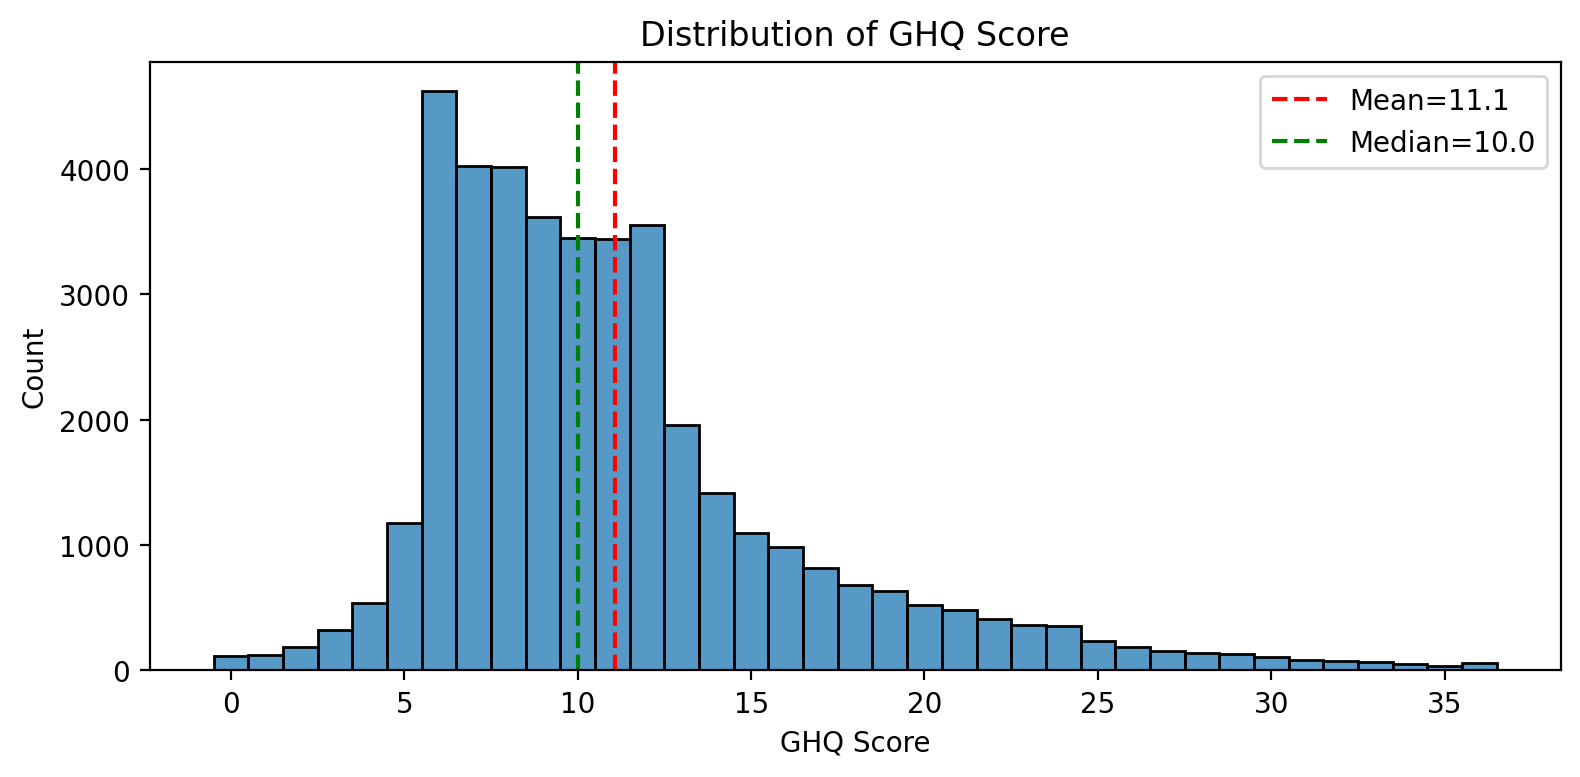

In [33]:
# Histogram of Y_processed (GHQ score)
bins = np.arange(Y_processed.min() - 0.5, Y_processed.max() + 1.5, 1)
plt.figure(figsize=(8, 4))
sns.histplot(Y_processed, bins=bins, stat="count", kde=False, color='C0')
plt.axvline(Y_processed.mean(), color="red", linestyle="--", label=f"Mean={Y_processed.mean():.1f}")
plt.axvline(Y_processed.median(), color="green", linestyle="--", label=f"Median={Y_processed.median():.1f}")
plt.title('Distribution of GHQ Score')
plt.xlabel('GHQ Score')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

Age distribution

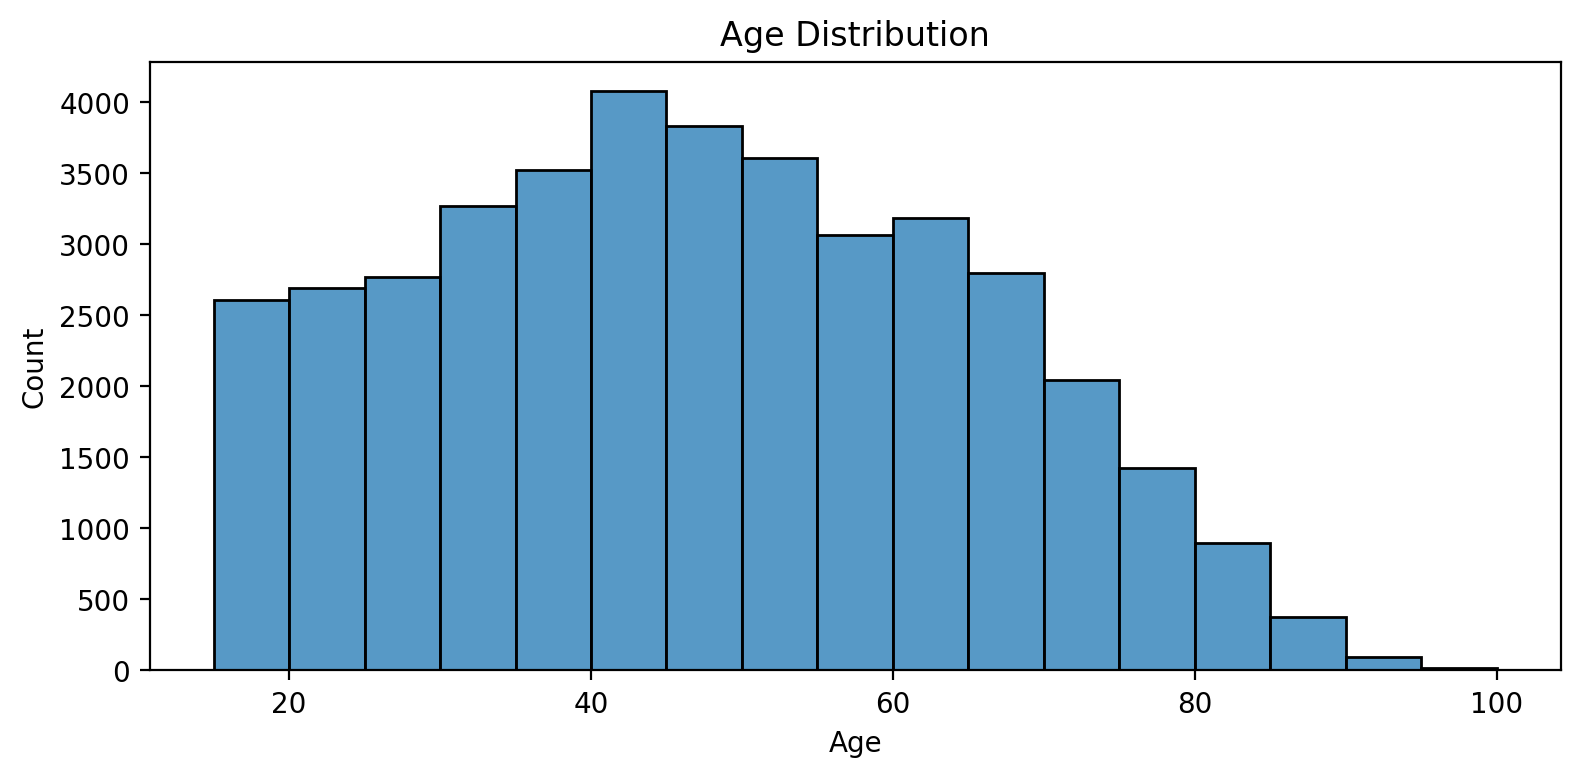

In [34]:

col = 'age_dv'
age_min = X[col].min()
age_max = X[col].max()

# bins of width 5, starting from the min value
bins = np.arange(age_min, age_max + 5, 5)

plt.figure(figsize=(8, 4))
sns.histplot(X[col], bins=bins, kde=False, color='C0')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Income

Income min: 0.0, max: 350391.5625


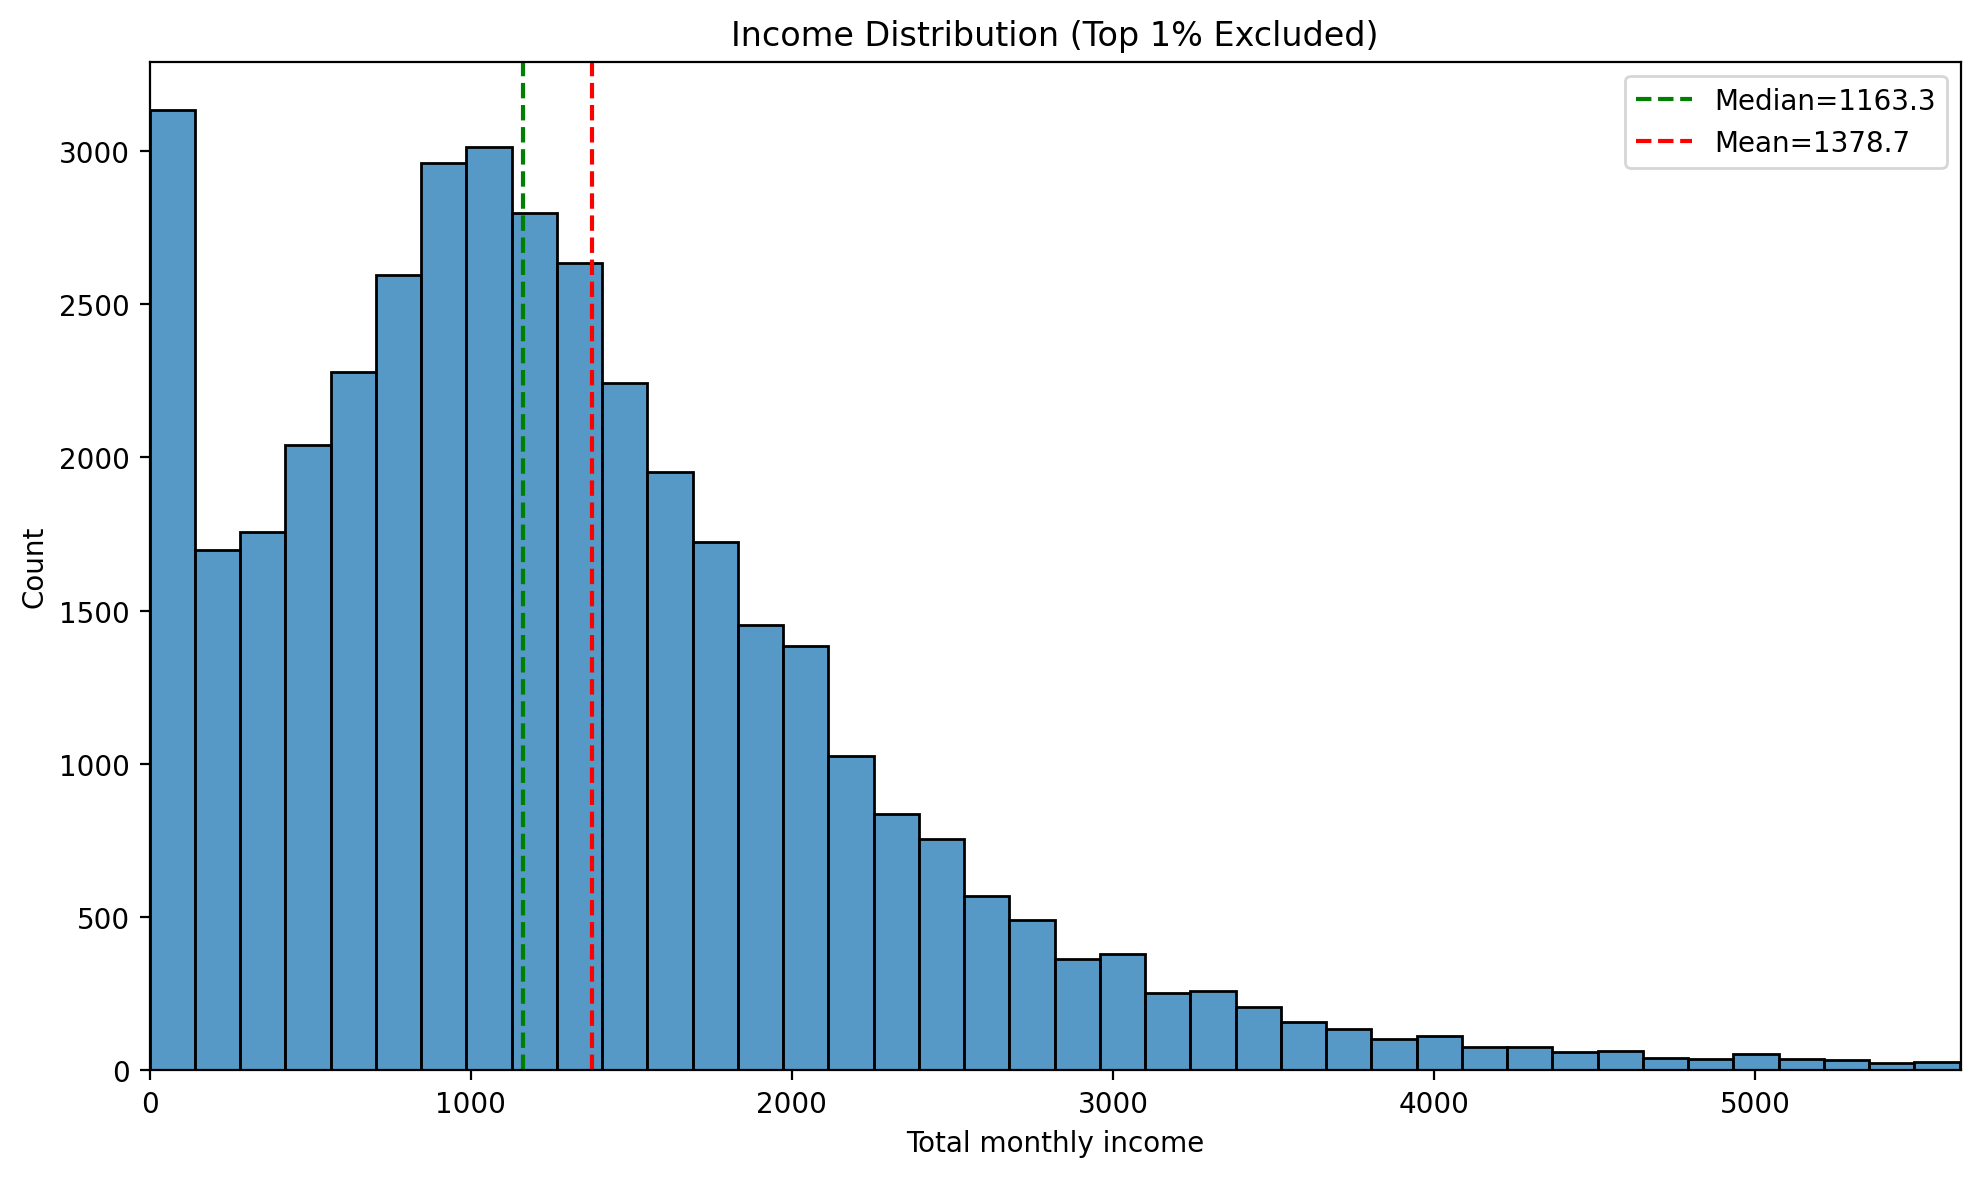

In [35]:
col = 'fimnnet_dv'
income_min = X[col].min()
income_max = X[col].max()

print(f"Income min: {income_min}, max: {income_max}")

plt.figure(figsize=(10, 6))
# Limit the x-axis to focus on the majority of the data (e.g., incomes below the 99th percentile)
upper_limit = np.percentile(X[col], 99)
sns.histplot(X[col][X[col] <= upper_limit], bins=40, kde=False, color='C0')
plt.xlim(X[col].min(), upper_limit)
plt.title('Income Distribution (Top 1% Excluded)')
plt.xlabel('Total monthly income')
plt.ylabel('Count')
plt.axvline(X[col].median(), color="green", linestyle="--", label=f"Median={X[col].median():.1f}")
plt.axvline(X[col].mean(), color="red", linestyle="--", label=f"Mean={X[col].mean():.1f}")
plt.legend()
plt.tight_layout()
plt.show()


Social cohesion (informal institutions)

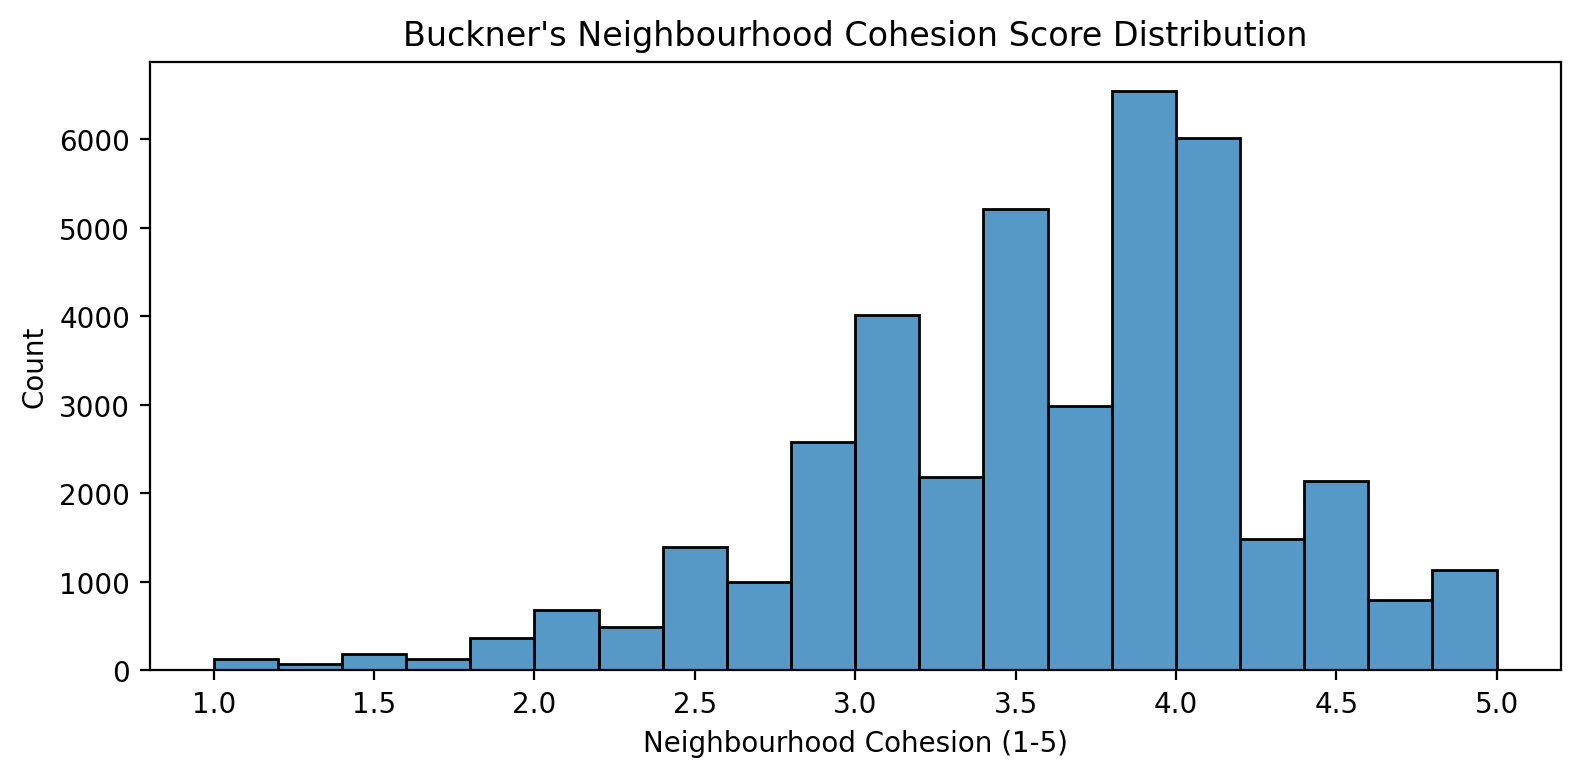

In [36]:
# Create histogram of nbrsnci_dv (neighbourhood cohesion)
col = 'nbrsnci_dv'
nbr_min = 1
nbr_max = 5

# bins of width 1, starting from the min value
bins = np.arange(nbr_min, nbr_max + 0.01, 0.2)

plt.figure(figsize=(8, 4))
sns.histplot(X[col], bins=bins, kde=False, color='C0')
plt.title("Buckner's Neighbourhood Cohesion Score Distribution")
plt.xlabel('Neighbourhood Cohesion (1-5)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



Location


Distribution of respondents by region:
                  Region  Count  Share
    South East (England)   4865   12.1
                  London   4405   10.9
    North West (England)   4100   10.2
                Scotland   3839    9.5
          East (England)   3412    8.5
    South West (England)   3319    8.2
                   Wales   3175    7.9
Yorkshire and The Humber   3079    7.7
 West Midlands (England)   3047    7.6
 East Midlands (England)   2827    7.0
        Northern Ireland   2648    6.6
    North East (England)   1520    3.8


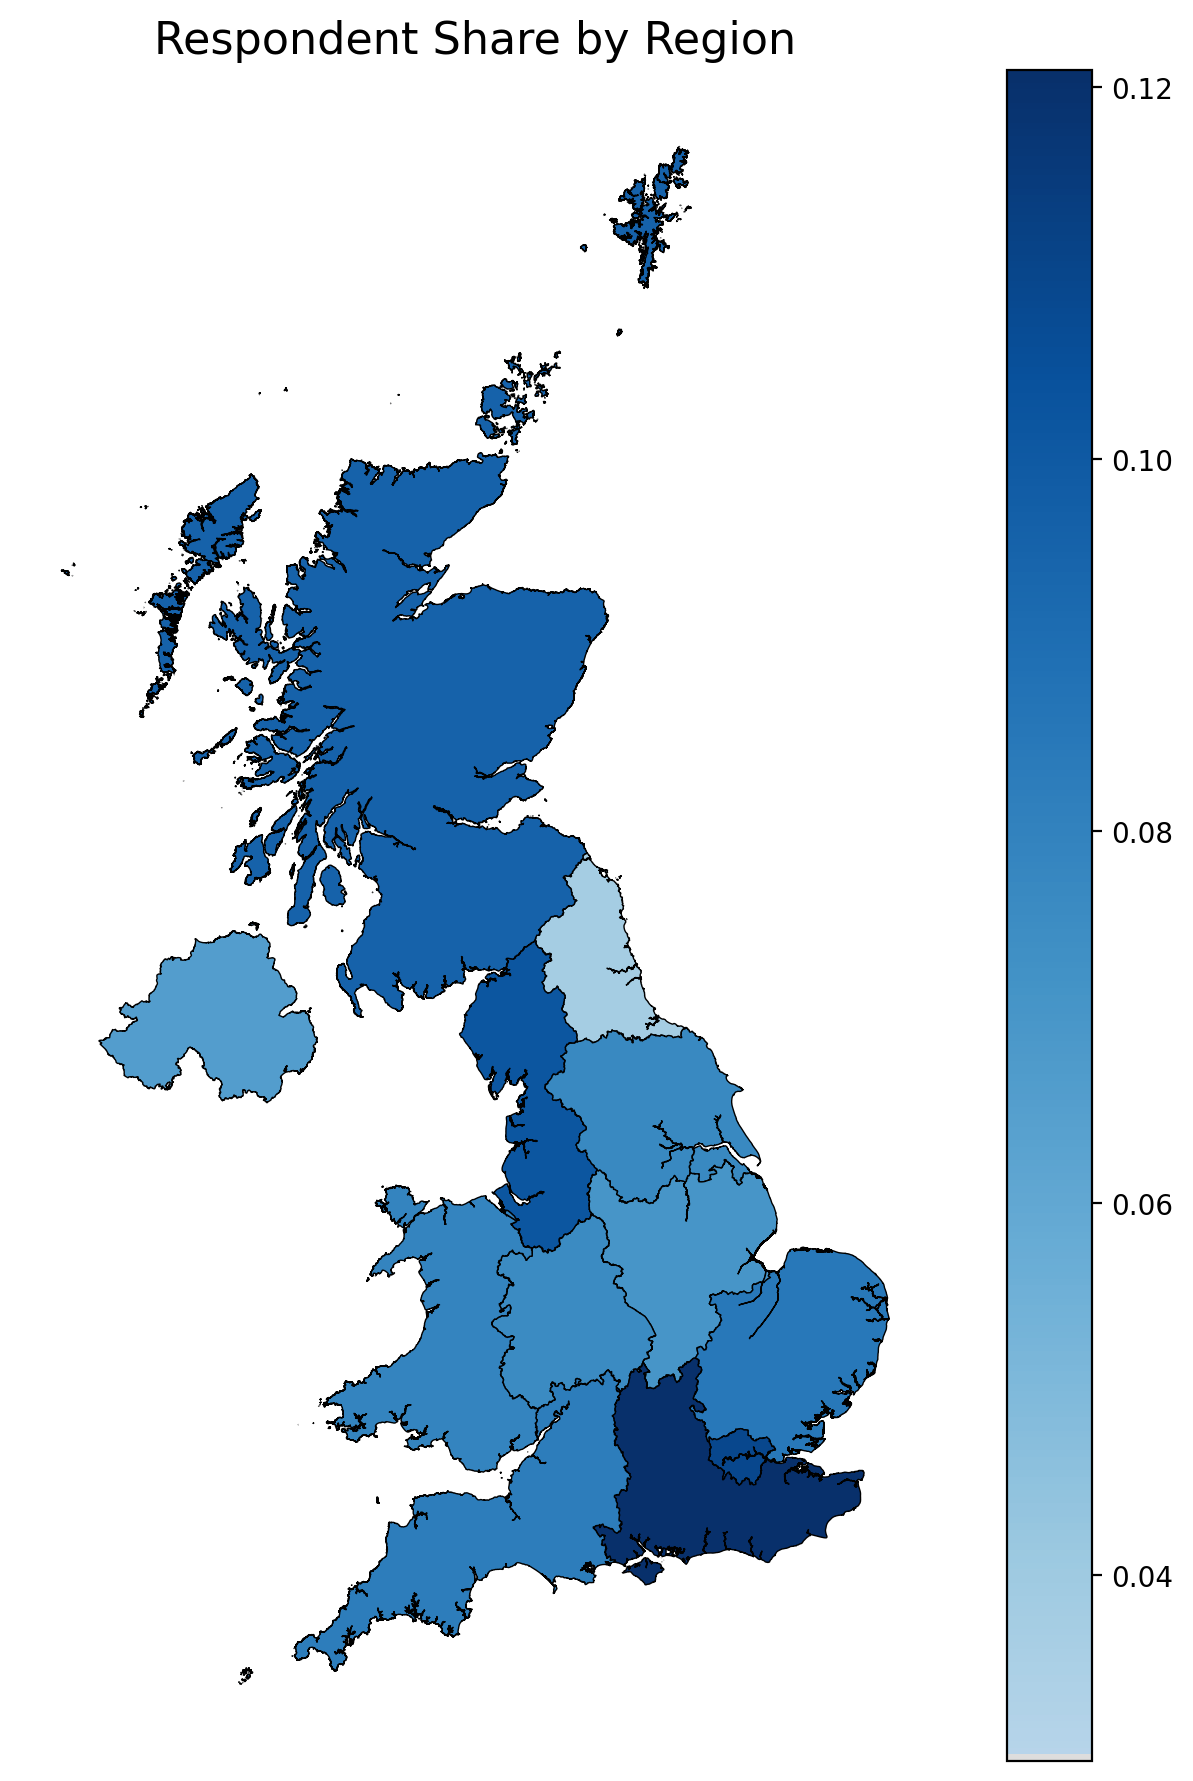

In [37]:
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

import numpy as np, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt

# --- 1) Load shapes and standardise the name column ---
PATH_TO_GEOJSON = "/Users/arikatz/VSCode Projects/ukhls-informal-institutions-project/data/gor_dv.geojson"
NAME_COL = "ITL125NM"          # <- check with: print(gpd.read_file(PATH_TO_GEOJSON).columns)
regions = gpd.read_file(PATH_TO_GEOJSON)[[NAME_COL, "geometry"]].rename(columns={NAME_COL:"Region"})

# --- 2) Map gor_dv codes to the EXACT strings used in the GeoJSON ---
# ITL1 2025 names look like this:
code_to_label_geojson = {
    1: "North East (England)",
    2: "North West (England)",
    3: "Yorkshire and The Humber",
    4: "East Midlands (England)",
    5: "West Midlands (England)",
    6: "East (England)",
    7: "London",
    8: "South East (England)",
    9: "South West (England)",
    10: "Wales",
    11: "Scotland",
    12: "Northern Ireland"
}

# --- 3) Build a tidy distribution table (counts + shares) ---
gor = (X["gor_dv"].astype(int)
                 .map(code_to_label_geojson))   # convert codes -> GeoJSON labels

dist = (gor.value_counts()                  # count occurrences of each label
          .rename_axis("Region")            # name the index
          .reset_index(name="Count")        # turn into a DataFrame
          .sort_values("Count", ascending=False)) # sort by count descending
dist["Share"] = dist["Count"] / dist["Count"].sum() # compute share

print("\nDistribution of respondents by region:")
print(dist.assign(Share=lambda d: (d["Share"]*100).round(1)).to_string(index=False)) # display as percentages.

# --- 4) Merge onto the polygons and plot ---
gdf = regions.merge(dist, on="Region", how="left").fillna({"Count":0, "Share":0.0})
fig, ax = plt.subplots(figsize=(8, 9))

# Custom colormap: start at light grey, then blend into Blues

from matplotlib.colors import to_rgba

# Convert "#dddddd" to RGBA and concatenate with Blues colormap
grey_rgba = np.array([to_rgba("#dddddd")])
blues_rgba = plt.cm.Blues(np.linspace(0.3, 1, 256))
colors = np.vstack([grey_rgba, blues_rgba])
custom_cmap = LinearSegmentedColormap.from_list("grey_blues", colors, N=256)

# Set vmin to 0.03 (3%) so that 3% is not mapped to the lightest grey
norm = Normalize(vmin=0.03, vmax=gdf["Share"].max(), clip=True)

gdf.plot(
    column="Share",
    cmap=custom_cmap,
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    norm=norm,
    ax=ax
)
ax.set_title("Respondent Share by Region", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()

Job status

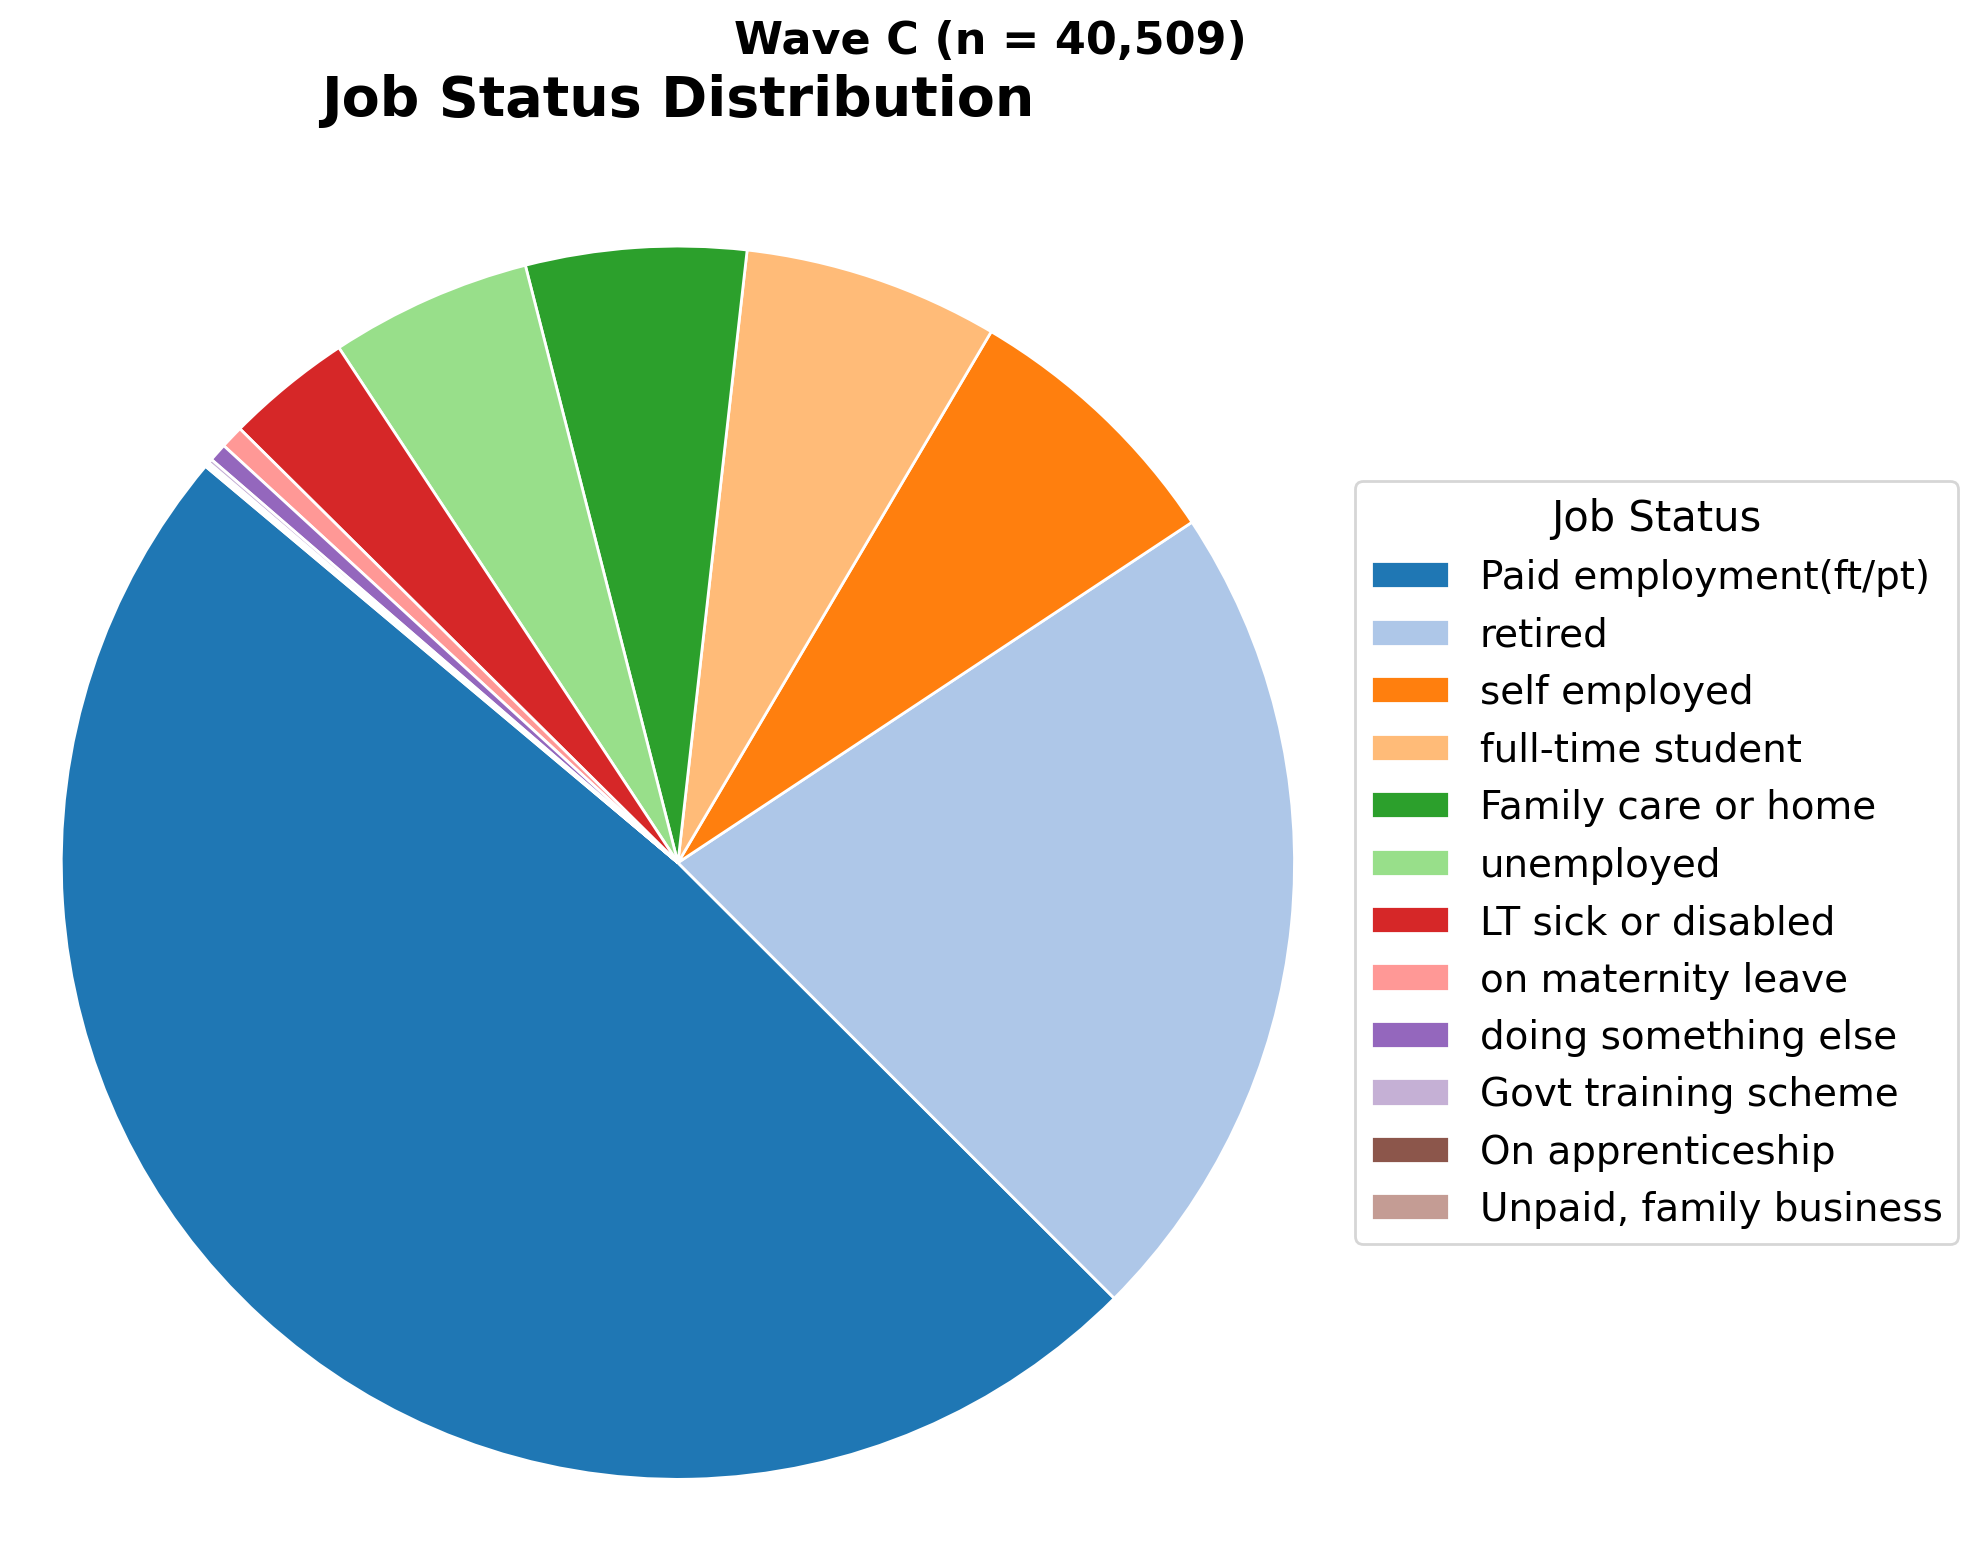

In [38]:
# Get job status value counts and labels
jb_counts = X['jbstat'].value_counts()
jb_labels_sorted = jb_counts.index.astype(int)
jb_sizes_sorted = jb_counts.values

# Get value labels from meta
jbstat_labelset = meta.variable_to_label.get('jbstat')
jbstat_labels = meta.value_labels.get(jbstat_labelset, {})
jb_labels_text = [jbstat_labels.get(code, str(code)) for code in jb_labels_sorted]

from matplotlib import cm

# Pie chart for job status: legend uses value labels from meta
cmap = plt.get_cmap('tab20')
pie_colors = [cmap(i) for i in range(len(jb_sizes_sorted))]

plt.figure(figsize=(10, 8))
plt.suptitle("Wave C (n = 40,509)", fontsize=16, weight='bold', y=0.97, ha='center')

wedges, _ = plt.pie(
    jb_sizes_sorted,
    labels=None,
    startangle=140,
    colors=pie_colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)

plt.legend(wedges, jb_labels_text, title="Job Status", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14, title_fontsize=15)
plt.title("Job Status Distribution", fontsize=20, weight='bold', pad=25, loc='center')
plt.axis("equal")
plt.tight_layout()
plt.show()


## Bivariate analysis

Age vs Income (by sex)

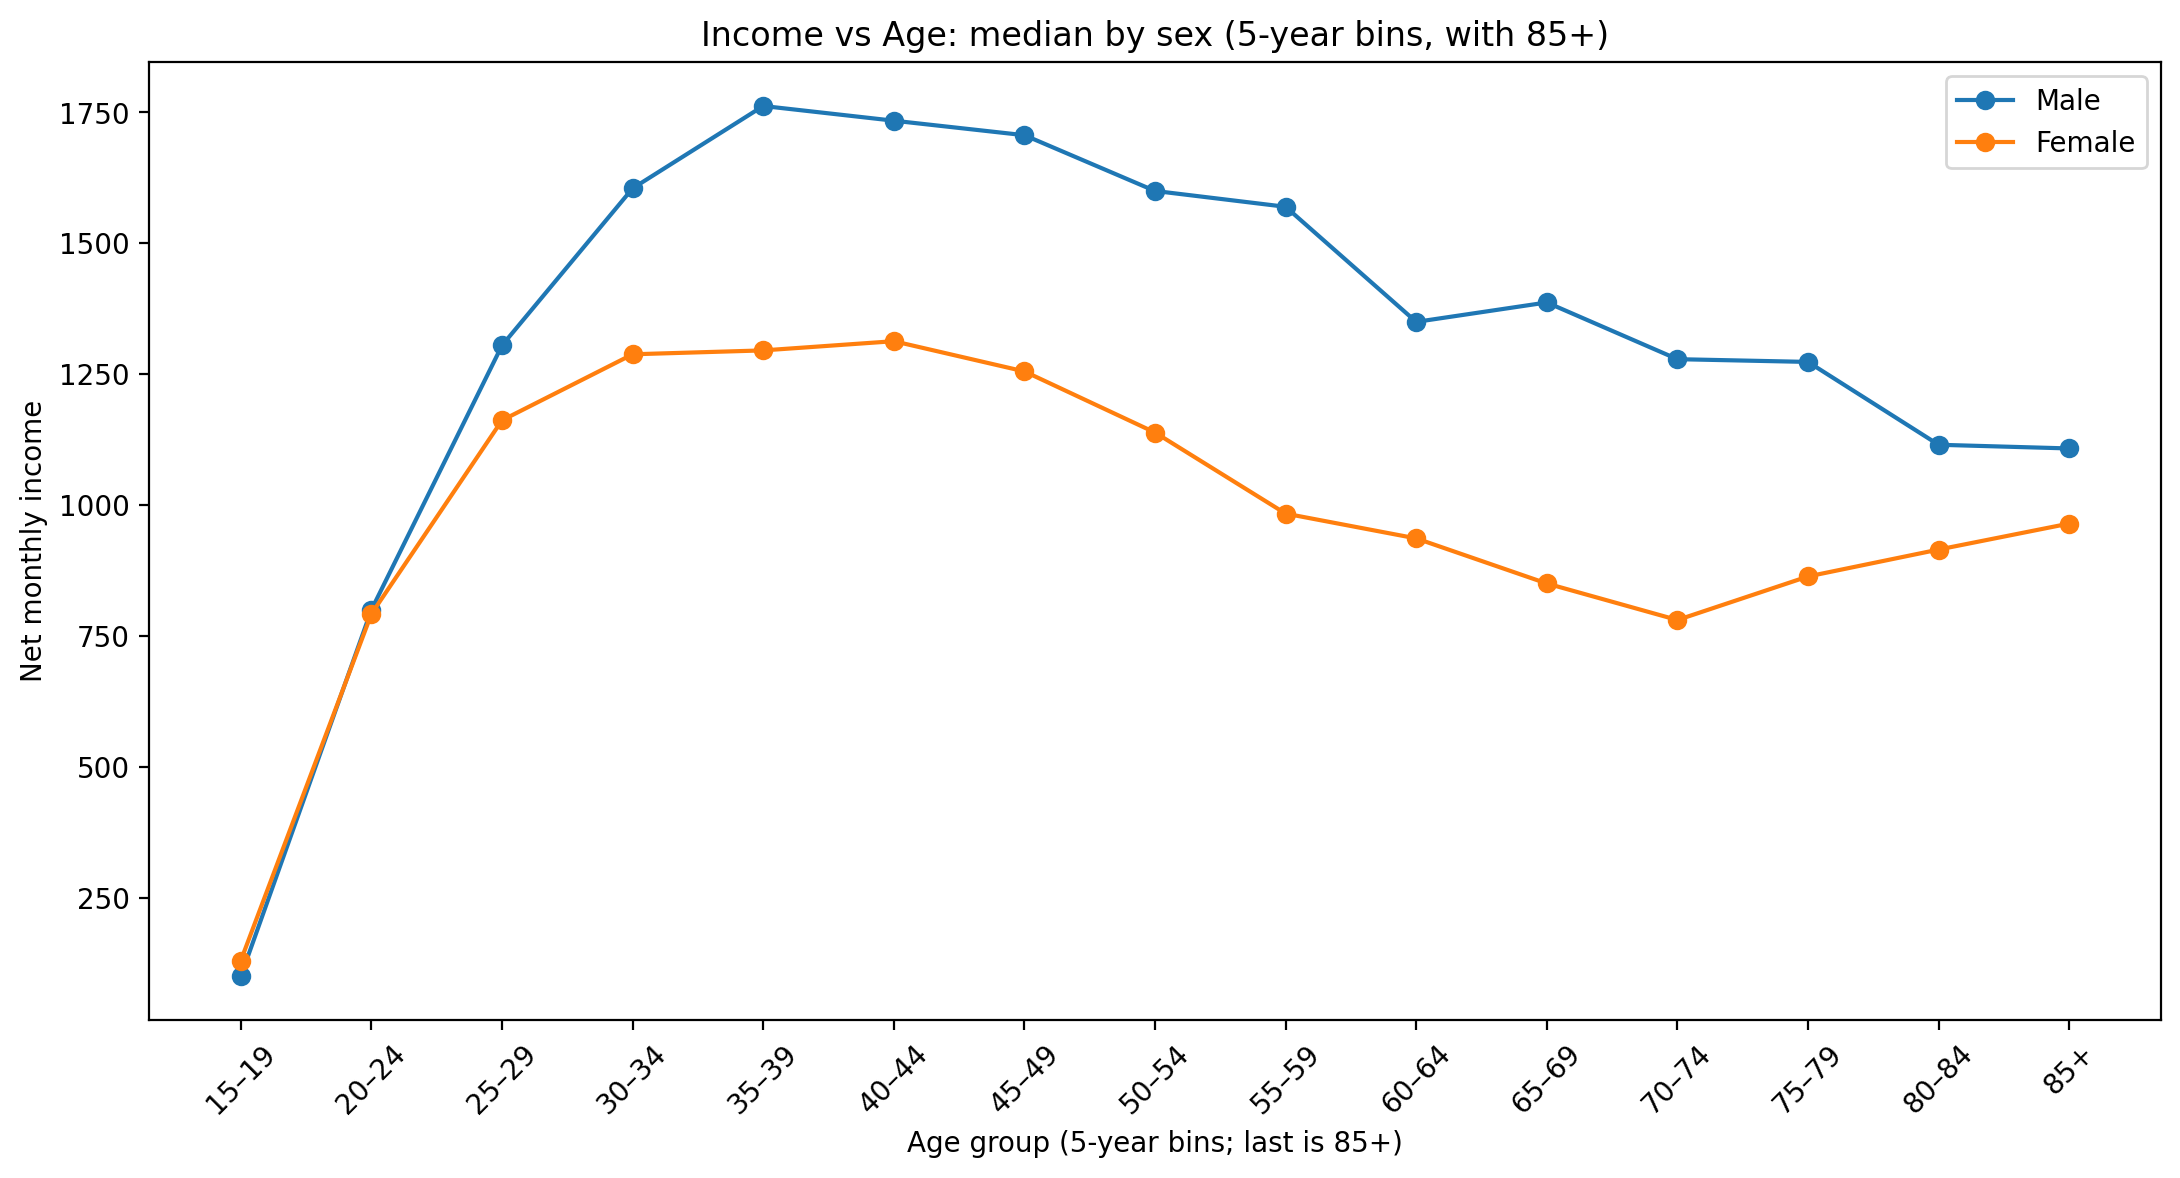

In [39]:
d = X.copy()

# --- 1) Define bins: 15–85 in 5-year steps, plus one open-ended 85+ bin ---
bins   = list(range(15, 86, 5)) + [120]        # last bin goes up to age 120
labels = [f"{b}–{b+4}" for b in range(15, 85, 5)] + ["85+"]

# --- 2) Helper to compute median by age-bin for one sex ---
def median_by_agebin(data, sex_code):
    sub = data.loc[data['sex_dv'] == sex_code, ['age_dv', 'fimnnet_dv']].copy()
    age_bin = pd.cut(sub['age_dv'], bins=bins, labels=labels, right=False)
    g = (
        sub.groupby(age_bin, observed=True)['fimnnet_dv']
           .median()
           .reindex(labels)  # keep bin order
    )
    return pd.DataFrame({
        'age_bin': labels,
        'median': g.values
    })

male   = median_by_agebin(d, 1)  # 1 = male
female = median_by_agebin(d, 2)  # 2 = female

# --- 3) Plot: two simple median lines with bin labels on x-axis ---
plt.figure(figsize=(11,6))
plt.plot(male['age_bin'],   male['median'],   marker='o', label='Male')
plt.plot(female['age_bin'], female['median'], marker='o', label='Female')

plt.xlabel('Age group (5-year bins; last is 85+)')
plt.ylabel('Net monthly income')
plt.title('Income vs Age: median by sex (5-year bins, with 85+)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Wellbeing vs Income (by sex)

Wellbeing vs Age (by sex)

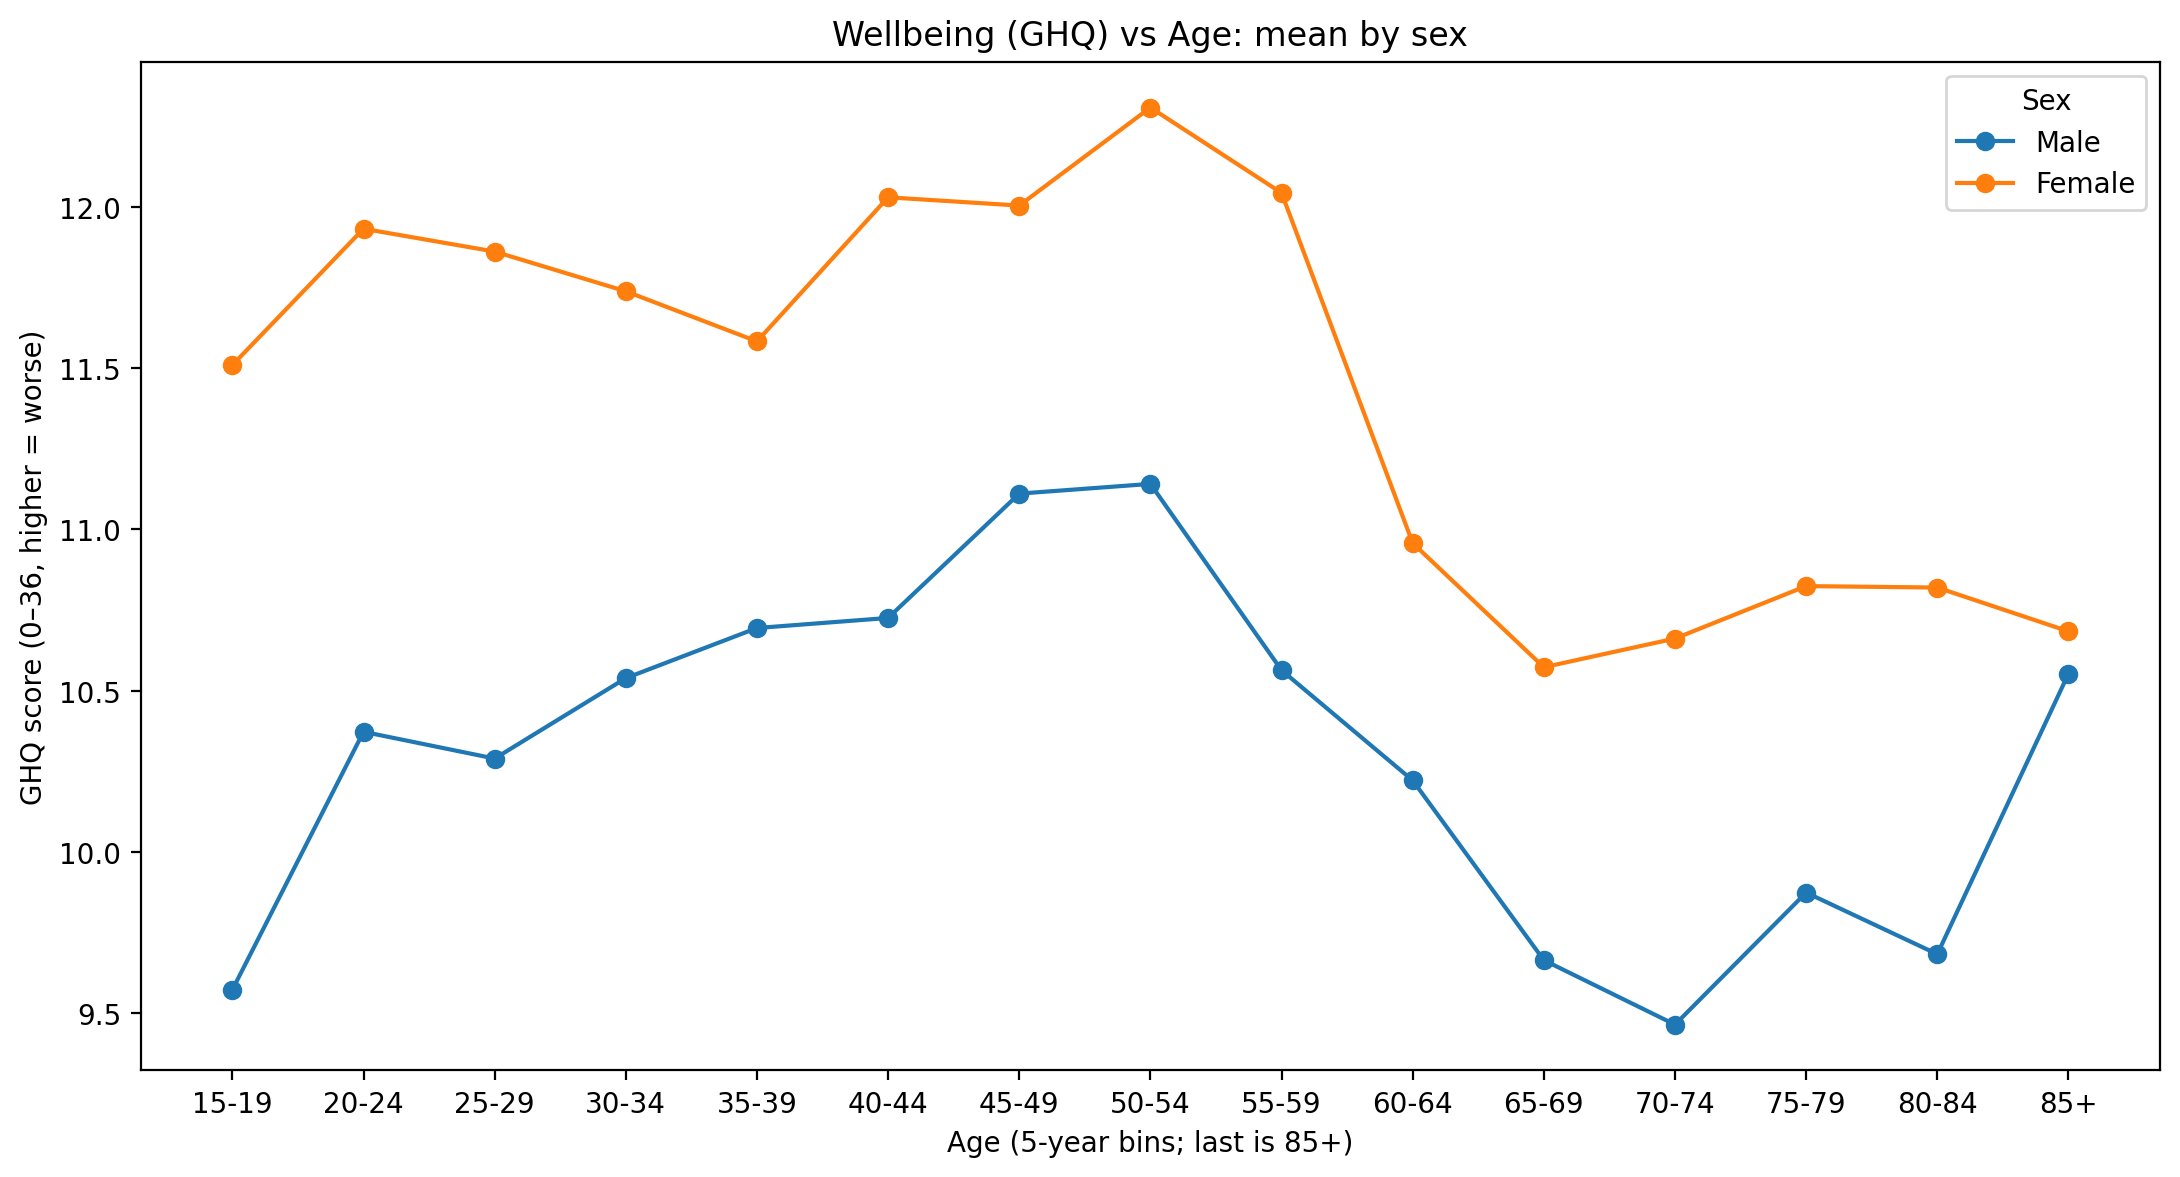

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- OPTIONS ----------
MIN_N_PER_BIN = 10      # hide bins with fewer observations
BINS = list(range(15, 86, 5)) + [120]   # 15–85 in 5-year bins, then one 85+ bin
BIN_LABELS = [f"{b}-{b+4}" for b in range(15, 85, 5)] + ["85+"]

# Use your main dataframe here
d = df.copy()   # or X.copy()

# Keep only relevant columns and drop missings
d = d[['age_dv', 'sex_dv', 'scghq1_dv']].dropna()
d = d[(d['scghq1_dv'] >= 0) & (d['scghq1_dv'] <= 36)]

# Make 5-year age bins (with a single 85+ bin)
d = d.assign(age_bin=pd.cut(d['age_dv'], bins=BINS, labels=BIN_LABELS, right=False))

def summarise_by_sex(data, sex_code):
    """Return mean and N of GHQ by age_bin for a given sex."""
    sub = data.loc[data['sex_dv'] == sex_code, ['age_bin', 'scghq1_dv']].copy()
    g = (sub.groupby('age_bin', observed=True)['scghq1_dv']
            .agg(mean='mean', n='count')
            .reindex(BIN_LABELS))  # preserve bin order
    return g

male   = summarise_by_sex(d, 1)   # 1 = male
female = summarise_by_sex(d, 2)   # 2 = female

# Apply mask for small bins
male_mask   = male['n']   >= MIN_N_PER_BIN
female_mask = female['n'] >= MIN_N_PER_BIN

x = np.arange(len(BIN_LABELS))

plt.figure(figsize=(11, 6))

# --- Male line (mean only) ---
plt.plot(x[male_mask], male.loc[male_mask, 'mean'], marker='o', label='Male')

# --- Female line (mean only) ---
plt.plot(x[female_mask], female.loc[female_mask, 'mean'], marker='o', label='Female')

# Cosmetics
plt.xticks(ticks=x, labels=BIN_LABELS, rotation=0)
plt.xlabel('Age (5-year bins; last is 85+)')
plt.ylabel('GHQ score (0–36, higher = worse)')
plt.title('Wellbeing (GHQ) vs Age: mean by sex')
plt.legend(title='Sex')
plt.tight_layout()
plt.show()

Informal institutions vs subjective wellbeing

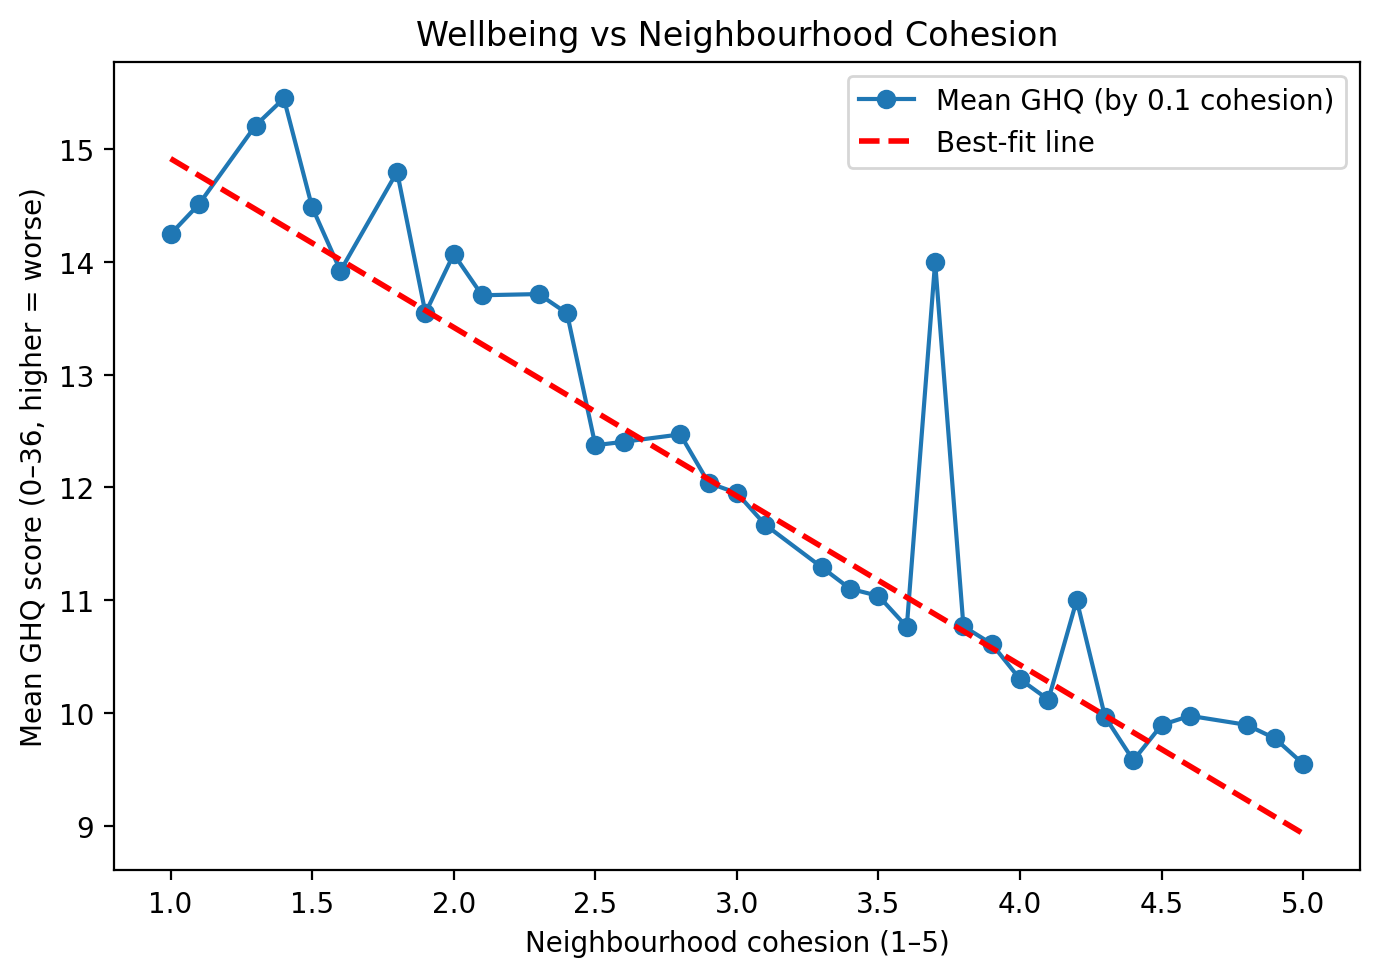

Best-fit line: GHQ ≈ -1.497 × cohesion + 16.415  (negative slope = better wellbeing with higher cohesion)


In [63]:
# 1) Keep only the two columns and drop rows with missing values
d = df[['nbrsnci_dv','scghq1_dv']].dropna()

# 2) Keep only valid ranges (safety: cohesion 1–5, GHQ 0–36)
d = d[d['nbrsnci_dv'].between(1, 5) & d['scghq1_dv'].between(0, 36)]

# 3) Make a very simple summary curve:
#    round cohesion to 1 decimal and take the mean GHQ at each rounded level
g = (d
     .groupby(d['nbrsnci_dv'].round(1))['scghq1_dv']
     .mean()
     .reset_index(name='mean_ghq')
     .rename(columns={'nbrsnci_dv':'cohesion'}))

# 4) Fit a straight line *on the raw cleaned data* (not on the summary),
#    so the fit isn’t biased by the grouping step
m, b = np.polyfit(d['nbrsnci_dv'], d['scghq1_dv'], 1)   # slope m, intercept b
xline = np.linspace(1, 5, 200)
yline = m * xline + b

# 5) Plot: the simple summary curve + the best-fit line
plt.figure(figsize=(7,5))
plt.plot(g['cohesion'], g['mean_ghq'], marker='o', label='Mean GHQ (by 0.1 cohesion)')
plt.plot(xline, yline, 'r--', lw=2, label='Best-fit line')

plt.xlabel("Neighbourhood cohesion (1–5)")
plt.ylabel("Mean GHQ score (0–36, higher = worse)")
plt.title("Wellbeing vs Neighbourhood Cohesion")
plt.legend()
plt.tight_layout()
plt.show()

# (optional) print the line equation so you can report it
print(f"Best-fit line: GHQ ≈ {m:.3f} × cohesion + {b:.3f}  (negative slope = better wellbeing with higher cohesion)")

In [61]:
# Correlation coefficient between neighbourhood cohesion and GHQ score
corr = d['nbrsnci_dv'].corr(d['scghq1_dv'])
print(f"Correlation coefficient between neighbourhood cohesion and GHQ score: {corr:.3f}")

Correlation coefficient between neighbourhood cohesion and GHQ score: -0.190


Wellbeing by region


Average GHQ by region (higher = worse):
                  Region  mean_ghq    n
 West Midlands (England)     11.38 3047
Yorkshire and The Humber     11.37 3079
                   Wales     11.36 3175
    North West (England)     11.35 4100
    North East (England)     11.34 1520
 East Midlands (England)     11.10 2827
                  London     11.06 4405
          East (England)     10.93 3412
        Northern Ireland     10.90 2648
    South East (England)     10.85 4865
    South West (England)     10.78 3319
                Scotland     10.73 3839


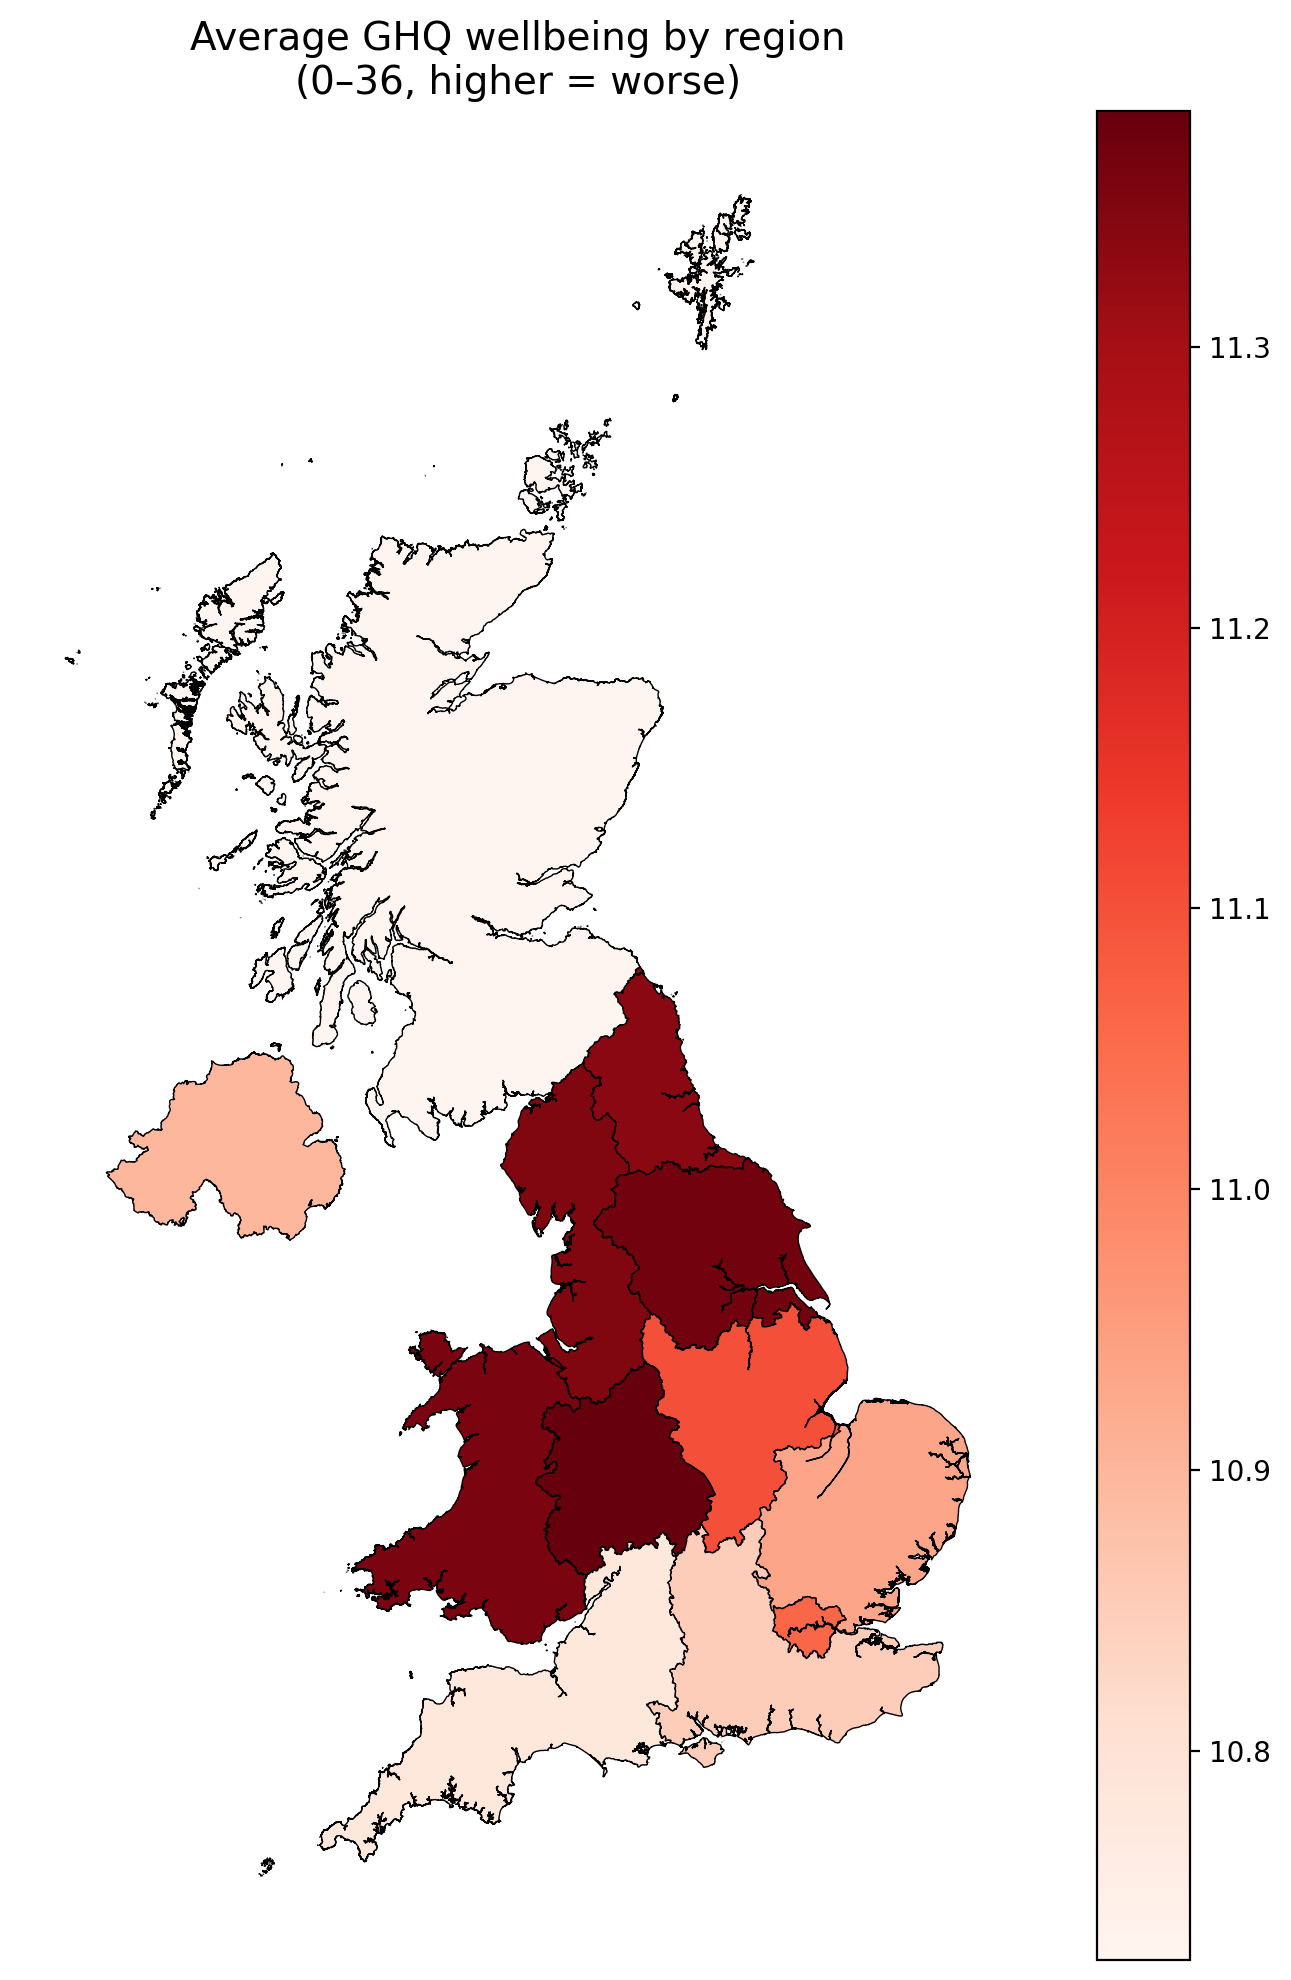

In [73]:
# ====== EDIT THESE TWO ======

PATH_TO_GEOJSON = "/Users/arikatz/VSCode Projects/ukhls-informal-institutions-project/data/gor_dv.geojson"
NAME_COL = "ITL125NM"  # change if your GeoJSON uses a different name column
# ============================

# 1) Load regions and standardise the name column
regions = gpd.read_file(PATH_TO_GEOJSON)[[NAME_COL, "geometry"]].rename(columns={NAME_COL: "Region"})

# 2) Map UKHLS region codes -> EXACT GeoJSON labels (ITL1 2025 style)
code_to_label_geojson = {
    1: "North East (England)",
    2: "North West (England)",
    3: "Yorkshire and The Humber",
    4: "East Midlands (England)",
    5: "West Midlands (England)",
    6: "East (England)",
    7: "London",
    8: "South East (England)",
    9: "South West (England)",
    10: "Wales",
    11: "Scotland",
    12: "Northern Ireland",
}

# 3) Build tidy table: mean GHQ and N by region
d = df[["gor_dv", "scghq1_dv"]].copy()  # or X if both columns live there
d["gor_dv"] = d["gor_dv"].replace({-9: np.nan})
d["scghq1_dv"] = d["scghq1_dv"].replace({-9: np.nan, -8: np.nan, -7: np.nan})
d = d.dropna()

d["Region"] = d["gor_dv"].astype(int).map(code_to_label_geojson)

wb = (
    d.groupby("Region", observed=True)["scghq1_dv"]
      .agg(mean_ghq="mean", n="count")
      .reset_index()
      .sort_values("mean_ghq", ascending=False)
)

# 4) Print a quick table (higher GHQ = worse wellbeing)
print("\nAverage GHQ by region (higher = worse):")
print(wb.assign(mean_ghq=lambda x: x["mean_ghq"].round(2)).to_string(index=False))

# 5) Merge with polygons; regions with no data get NaN
gdf = regions.merge(wb, on="Region", how="left")

# 6) Plot: sequential red scale (darker red = worse wellbeing)
fig, ax = plt.subplots(figsize=(8.5, 10))
gdf.plot(
    column="mean_ghq",
    cmap="Reds",
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    ax=ax,
)
ax.set_title("Average GHQ wellbeing by region\n(0–36, higher = worse)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

# (optional) sanity checks for name mismatches
not_in_map = set(wb["Region"]) - set(regions["Region"])
if not_in_map:
    print("\nWarning: in data but not in map ->", not_in_map)
not_in_data = set(regions["Region"]) - set(wb["Region"])
if not_in_data:
    print("Note: in map but no data ->", not_in_data)

Do other ones? The nominal ones?

## Regression models

In [41]:
# Lasso regression with cross-validation

from sklearn.linear_model import LassoCV
import pandas as pd
import numpy as np

# ---- config ---------------------------------------------------------------
CONTINUOUS = ['nbrsnci_dv', 'age_dv', 'fimnnet_dv', 'fihhmnnet1_dv', 'houscost1_dv']

def parse_dummy(colname: str):
    """
    If column is a dummy like 'jbstat_8', return (base_var, 8) else (None, None).
    Uses rsplit so bases with underscores still work.
    """
    if '_' not in colname:
        return None, None
    base, suffix = colname.rsplit('_', 1)
    return (base, int(suffix)) if suffix.lstrip('-').isdigit() else (None, None)

def value_label_for(base_var: str, code: int, meta):
    """
    meta.variable_to_label maps var -> labelset name
    meta.value_labels maps labelset name -> {code: label}
    """
    labelset = meta.variable_to_label.get(base_var)
    if not labelset:
        return None
    return meta.value_labels.get(labelset, {}).get(code)

def var_label(var: str, meta):
    """Human label for a column, including category if it’s a dummy."""
    base, code = parse_dummy(var)
    if base is None:  # continuous or already-binary (0/1) variable
        return meta.column_names_to_labels.get(var, var)

    base_label = meta.column_names_to_labels.get(base, base)
    cat_label = value_label_for(base, code, meta)
    if cat_label is None:
        cat_label = str(code)
    return f"{base_label}: {cat_label}"

def category_only(var: str, meta):
    """Category text for the 'Category' column; empty for non-dummies."""
    base, code = parse_dummy(var)
    if base is None:
        return ""
    cat_label = value_label_for(base, code, meta)
    return cat_label if cat_label is not None else f"Category {code}"

# ---- fit model ------------------------------------------------------------
alphas = np.logspace(-4, 0, 100)  # Range of alpha values to try
lasso = LassoCV(cv=5, random_state=0, alphas=alphas)
lasso.fit(X_processed, Y_processed)

# ---- build coefficient table ---------------------------------------------
coef_df = pd.DataFrame({
    "Variable": X_processed.columns,
    "Coefficient": lasso.coef_
})
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df["Label"]    = coef_df["Variable"].apply(lambda v: var_label(v, meta))
coef_df["Category"] = coef_df["Variable"].apply(lambda v: category_only(v, meta))

# keep only non-zeros (Lasso makes some exactly zero)
non_zero = coef_df.loc[coef_df["Coefficient"] != 0].sort_values("Abs_Coefficient", ascending=False).reset_index(drop=True)

print(f"Number of non-zero coefficients: {len(non_zero)}")
display_cols = ["Variable", "Coefficient", "Label", "Category"]
non_zero[display_cols].head(60)



Number of non-zero coefficients: 54


,Variable,Coefficient,Label,Category
0,jbstat_8,5.254032,Current economic activity: LT sick or disabled,LT sick or disabled
1,health,-2.271059,Long-standing illness or disability,
2,jbstat_3,2.167115,Current economic activity: unemployed,unemployed
3,sex_dv,1.175816,"Sex, derived",
4,ethn_dv_16,-1.095527,Ethnic group (derived from multiple sources): ...,any other black background
5,marstat_dv_5,1.043533,Harmonised de facto marital status: Separated ...,Separated (incl. from civil partner)
6,nbrsnci_dv,-0.988343,"Buckner's Neighbourhood Cohesion Instrument, s...",
7,ethn_dv_10,0.934207,Ethnic group (derived from multiple sources): ...,pakistani
8,jbstat_11,-0.903107,Current economic activity: On apprenticeship,On apprenticeship
9,jbstat_6,0.875061,Current economic activity: Family care or home,Family care or home


In [42]:
# Run standard linear regression and show coefficients with p-values, sorted by absolute coefficient

X_sm = sm.add_constant(X_processed)
model = sm.OLS(Y_processed, X_sm).fit()
results_summary = model.summary2().tables[1]

results_summary = results_summary.rename(columns={"Coef.": "Coefficient", "P>|t|": "P-value"})
results_summary = results_summary.reset_index().rename(columns={"index": "Variable"})
results_summary["Abs_Coefficient"] = results_summary["Coefficient"].abs()
results_summary = results_summary.sort_values(by="Abs_Coefficient", ascending=False)

results_summary[["Variable", "Coefficient", "P-value"]].head(20)

,Variable,Coefficient,P-value
0,const,8.891989,8.079681e-02
48,jbstat_8,5.260316,1.476005e-193
40,marstat_dv_5,3.787790,4.569957e-01
39,marstat_dv_4,3.229065,5.258352e-01
38,marstat_dv_3,2.852419,5.752536e-01
36,marstat_dv_1,2.716117,5.935514e-01
37,marstat_dv_2,2.632638,6.049817e-01
41,marstat_dv_6,2.517108,6.208548e-01
8,health,-2.271741,0.000000e+00
43,jbstat_3,2.171050,6.277975e-47
